In [73]:
import torch

print("PyTorch version:", torch.__version__)

print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1
Is CUDA available?: True
GPU Name: NVIDIA GeForce RTX 4070
CUDA version: 12.1


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [75]:
# Set dataset paths based on extracted ZIP folder
base_path = 'RAFDB'  # Adjusted base path
train_path = os.path.join(base_path, 'train')  # Training images
validation_path = os.path.join(base_path, 'test')  # Test 

# Dynamically count labels (avoid manual mismatch)
LABELS = sorted(os.listdir(train_path))  # Get class names from folder structure
nb_classes = len(LABELS)  # Automatically set the number of classes

# Display detected classes
print(f"Classes detected: {LABELS}")
print(f"Number of classes: {nb_classes}")

Classes detected: ['1', '2', '3', '4', '5', '6', '7']
Number of classes: 7


In [76]:
# Define data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                     
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))     
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

In [77]:
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=validation_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [78]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=7):
        super(CNN, self).__init__()

        # con layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14
        )

        #  flatten 
        self.flattened_size = self._get_flattened_size(input_shape)

        # fc layer
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, num_classes)
        )


    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.conv_layers(dummy_input)
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(input_shape=(3, 224, 224), num_classes=nb_classes).to(device)


In [80]:
# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)

In [81]:
# Training model
best_val_acc = 0.0
save_path = "best_model.pth"
num_epochs = 100
patience = 7  # Early Stop Patience Value
no_improve_epochs = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        progress_bar.set_postfix({"loss": f"{running_loss / len(train_loader):.4f}", "accuracy": f"{correct / total:.4f}"})
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    cnn_model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn_model.state_dict(), save_path)
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

# Load the best model and print the accuracy
cnn_model.load_state_dict(torch.load(save_path))
print(f"Loaded best model with accuracy: {best_val_acc:.2f}%")


Epoch 1/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.29batch/s, loss=1.6127, accuracy=0.3987]


Epoch 1/100, Train Loss: 1.6127, Val Loss: 1.3376, Train Acc: 39.87%, Val Acc: 50.95%


Epoch 2/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=1.3666, accuracy=0.4930]


Epoch 2/100, Train Loss: 1.3666, Val Loss: 1.2080, Train Acc: 49.30%, Val Acc: 56.06%


Epoch 3/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.33batch/s, loss=1.2627, accuracy=0.5377]


Epoch 3/100, Train Loss: 1.2627, Val Loss: 1.1019, Train Acc: 53.77%, Val Acc: 64.31%


Epoch 4/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.21batch/s, loss=1.2007, accuracy=0.5692]


Epoch 4/100, Train Loss: 1.2007, Val Loss: 1.0668, Train Acc: 56.92%, Val Acc: 63.23%


Epoch 5/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.20batch/s, loss=1.1332, accuracy=0.5940]


Epoch 5/100, Train Loss: 1.1332, Val Loss: 0.9673, Train Acc: 59.40%, Val Acc: 66.88%


Epoch 6/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.31batch/s, loss=1.0664, accuracy=0.6202]


Epoch 6/100, Train Loss: 1.0664, Val Loss: 0.9164, Train Acc: 62.02%, Val Acc: 68.87%


Epoch 7/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.24batch/s, loss=1.0444, accuracy=0.6349]


Epoch 7/100, Train Loss: 1.0444, Val Loss: 0.8918, Train Acc: 63.49%, Val Acc: 71.38%


Epoch 8/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.24batch/s, loss=1.0040, accuracy=0.6501]


Epoch 8/100, Train Loss: 1.0040, Val Loss: 0.8466, Train Acc: 65.01%, Val Acc: 72.03%


Epoch 9/100: 100%|██████████████████████████████████| 192/192 [00:23<00:00,  8.32batch/s, loss=0.9647, accuracy=0.6632]


Epoch 9/100, Train Loss: 0.9647, Val Loss: 0.8238, Train Acc: 66.32%, Val Acc: 72.49%


Epoch 10/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.31batch/s, loss=0.9337, accuracy=0.6769]


Epoch 10/100, Train Loss: 0.9337, Val Loss: 0.8104, Train Acc: 67.69%, Val Acc: 72.59%


Epoch 11/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.30batch/s, loss=0.9209, accuracy=0.6778]


Epoch 11/100, Train Loss: 0.9209, Val Loss: 0.7855, Train Acc: 67.78%, Val Acc: 73.73%


Epoch 12/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.24batch/s, loss=0.8845, accuracy=0.6895]


Epoch 12/100, Train Loss: 0.8845, Val Loss: 0.7656, Train Acc: 68.95%, Val Acc: 73.79%


Epoch 13/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.18batch/s, loss=0.8777, accuracy=0.6939]


Epoch 13/100, Train Loss: 0.8777, Val Loss: 0.7395, Train Acc: 69.39%, Val Acc: 74.67%


Epoch 14/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=0.8544, accuracy=0.7060]


Epoch 14/100, Train Loss: 0.8544, Val Loss: 0.7669, Train Acc: 70.60%, Val Acc: 74.32%


Epoch 15/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.20batch/s, loss=0.8479, accuracy=0.7049]


Epoch 15/100, Train Loss: 0.8479, Val Loss: 0.7253, Train Acc: 70.49%, Val Acc: 75.59%


Epoch 16/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.23batch/s, loss=0.8261, accuracy=0.7123]


Epoch 16/100, Train Loss: 0.8261, Val Loss: 0.7466, Train Acc: 71.23%, Val Acc: 74.09%


Epoch 17/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.27batch/s, loss=0.8052, accuracy=0.7190]


Epoch 17/100, Train Loss: 0.8052, Val Loss: 0.6961, Train Acc: 71.90%, Val Acc: 75.95%


Epoch 18/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=0.7892, accuracy=0.7225]


Epoch 18/100, Train Loss: 0.7892, Val Loss: 0.7281, Train Acc: 72.25%, Val Acc: 74.97%


Epoch 19/100: 100%|█████████████████████████████████| 192/192 [00:22<00:00,  8.36batch/s, loss=0.7737, accuracy=0.7300]


Epoch 19/100, Train Loss: 0.7737, Val Loss: 0.6986, Train Acc: 73.00%, Val Acc: 77.05%


Epoch 20/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=0.7671, accuracy=0.7399]


Epoch 20/100, Train Loss: 0.7671, Val Loss: 0.6861, Train Acc: 73.99%, Val Acc: 76.01%


Epoch 21/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.29batch/s, loss=0.7566, accuracy=0.7348]


Epoch 21/100, Train Loss: 0.7566, Val Loss: 0.6769, Train Acc: 73.48%, Val Acc: 76.43%


Epoch 22/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.29batch/s, loss=0.7295, accuracy=0.7468]


Epoch 22/100, Train Loss: 0.7295, Val Loss: 0.6886, Train Acc: 74.68%, Val Acc: 76.17%


Epoch 23/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.28batch/s, loss=0.7134, accuracy=0.7527]


Epoch 23/100, Train Loss: 0.7134, Val Loss: 0.6542, Train Acc: 75.27%, Val Acc: 77.61%


Epoch 24/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.32batch/s, loss=0.7127, accuracy=0.7537]


Epoch 24/100, Train Loss: 0.7127, Val Loss: 0.6593, Train Acc: 75.37%, Val Acc: 77.61%


Epoch 25/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.22batch/s, loss=0.7092, accuracy=0.7507]


Epoch 25/100, Train Loss: 0.7092, Val Loss: 0.6625, Train Acc: 75.07%, Val Acc: 77.25%


Epoch 26/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.22batch/s, loss=0.6870, accuracy=0.7594]


Epoch 26/100, Train Loss: 0.6870, Val Loss: 0.6543, Train Acc: 75.94%, Val Acc: 78.23%


Epoch 27/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.32batch/s, loss=0.6930, accuracy=0.7587]


Epoch 27/100, Train Loss: 0.6930, Val Loss: 0.6449, Train Acc: 75.87%, Val Acc: 78.10%


Epoch 28/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.21batch/s, loss=0.6807, accuracy=0.7651]


Epoch 28/100, Train Loss: 0.6807, Val Loss: 0.6607, Train Acc: 76.51%, Val Acc: 78.32%


Epoch 29/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.33batch/s, loss=0.6655, accuracy=0.7678]


Epoch 29/100, Train Loss: 0.6655, Val Loss: 0.6923, Train Acc: 76.78%, Val Acc: 75.68%


Epoch 30/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.29batch/s, loss=0.6533, accuracy=0.7735]


Epoch 30/100, Train Loss: 0.6533, Val Loss: 0.6434, Train Acc: 77.35%, Val Acc: 78.29%


Epoch 31/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.22batch/s, loss=0.6494, accuracy=0.7743]


Epoch 31/100, Train Loss: 0.6494, Val Loss: 0.6295, Train Acc: 77.43%, Val Acc: 78.49%


Epoch 32/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.33batch/s, loss=0.6406, accuracy=0.7744]


Epoch 32/100, Train Loss: 0.6406, Val Loss: 0.6389, Train Acc: 77.44%, Val Acc: 78.62%


Epoch 33/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=0.6332, accuracy=0.7775]


Epoch 33/100, Train Loss: 0.6332, Val Loss: 0.6315, Train Acc: 77.75%, Val Acc: 79.07%


Epoch 34/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.26batch/s, loss=0.6251, accuracy=0.7841]


Epoch 34/100, Train Loss: 0.6251, Val Loss: 0.6235, Train Acc: 78.41%, Val Acc: 79.20%


Epoch 35/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.32batch/s, loss=0.6181, accuracy=0.7839]


Epoch 35/100, Train Loss: 0.6181, Val Loss: 0.6394, Train Acc: 78.39%, Val Acc: 79.30%


Epoch 36/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.25batch/s, loss=0.6189, accuracy=0.7844]


Epoch 36/100, Train Loss: 0.6189, Val Loss: 0.6264, Train Acc: 78.44%, Val Acc: 79.63%


Epoch 37/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.24batch/s, loss=0.5994, accuracy=0.7911]


Epoch 37/100, Train Loss: 0.5994, Val Loss: 0.6016, Train Acc: 79.11%, Val Acc: 79.07%


Epoch 38/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.27batch/s, loss=0.5926, accuracy=0.7885]


Epoch 38/100, Train Loss: 0.5926, Val Loss: 0.6222, Train Acc: 78.85%, Val Acc: 80.05%


Epoch 39/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.12batch/s, loss=0.5942, accuracy=0.7949]


Epoch 39/100, Train Loss: 0.5942, Val Loss: 0.5909, Train Acc: 79.49%, Val Acc: 80.48%


Epoch 40/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.15batch/s, loss=0.5932, accuracy=0.7945]


Epoch 40/100, Train Loss: 0.5932, Val Loss: 0.6140, Train Acc: 79.45%, Val Acc: 78.81%


Epoch 41/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.10batch/s, loss=0.5703, accuracy=0.7998]


Epoch 41/100, Train Loss: 0.5703, Val Loss: 0.6149, Train Acc: 79.98%, Val Acc: 79.11%


Epoch 42/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.12batch/s, loss=0.5665, accuracy=0.7977]


Epoch 42/100, Train Loss: 0.5665, Val Loss: 0.6116, Train Acc: 79.77%, Val Acc: 79.24%


Epoch 43/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.13batch/s, loss=0.5684, accuracy=0.7989]


Epoch 43/100, Train Loss: 0.5684, Val Loss: 0.5931, Train Acc: 79.89%, Val Acc: 79.89%


Epoch 44/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.06batch/s, loss=0.5616, accuracy=0.7986]


Epoch 44/100, Train Loss: 0.5616, Val Loss: 0.5946, Train Acc: 79.86%, Val Acc: 79.76%


Epoch 45/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.26batch/s, loss=0.5536, accuracy=0.8049]


Epoch 45/100, Train Loss: 0.5536, Val Loss: 0.6022, Train Acc: 80.49%, Val Acc: 79.43%


Epoch 46/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.76batch/s, loss=0.5411, accuracy=0.8045]


Epoch 46/100, Train Loss: 0.5411, Val Loss: 0.5835, Train Acc: 80.45%, Val Acc: 80.54%


Epoch 47/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.78batch/s, loss=0.5406, accuracy=0.8103]


Epoch 47/100, Train Loss: 0.5406, Val Loss: 0.5951, Train Acc: 81.03%, Val Acc: 79.76%


Epoch 48/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.78batch/s, loss=0.5459, accuracy=0.8061]


Epoch 48/100, Train Loss: 0.5459, Val Loss: 0.5759, Train Acc: 80.61%, Val Acc: 81.26%


Epoch 49/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.89batch/s, loss=0.5247, accuracy=0.8137]


Epoch 49/100, Train Loss: 0.5247, Val Loss: 0.5903, Train Acc: 81.37%, Val Acc: 80.74%


Epoch 50/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.95batch/s, loss=0.5310, accuracy=0.8108]


Epoch 50/100, Train Loss: 0.5310, Val Loss: 0.5830, Train Acc: 81.08%, Val Acc: 80.77%


Epoch 51/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.89batch/s, loss=0.5203, accuracy=0.8195]


Epoch 51/100, Train Loss: 0.5203, Val Loss: 0.6251, Train Acc: 81.95%, Val Acc: 79.53%


Epoch 52/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.88batch/s, loss=0.5220, accuracy=0.8177]


Epoch 52/100, Train Loss: 0.5220, Val Loss: 0.5907, Train Acc: 81.77%, Val Acc: 80.48%


Epoch 53/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.96batch/s, loss=0.5166, accuracy=0.8191]


Epoch 53/100, Train Loss: 0.5166, Val Loss: 0.6005, Train Acc: 81.91%, Val Acc: 81.19%


Epoch 54/100: 100%|█████████████████████████████████| 192/192 [00:24<00:00,  7.96batch/s, loss=0.5068, accuracy=0.8210]


Epoch 54/100, Train Loss: 0.5068, Val Loss: 0.5905, Train Acc: 82.10%, Val Acc: 80.93%


Epoch 55/100: 100%|█████████████████████████████████| 192/192 [00:23<00:00,  8.23batch/s, loss=0.4863, accuracy=0.8271]


Epoch 55/100, Train Loss: 0.4863, Val Loss: 0.6024, Train Acc: 82.71%, Val Acc: 79.99%
Early stopping triggered.
Loaded best model with accuracy: 81.26%


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7484\1043822507.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(save_path))


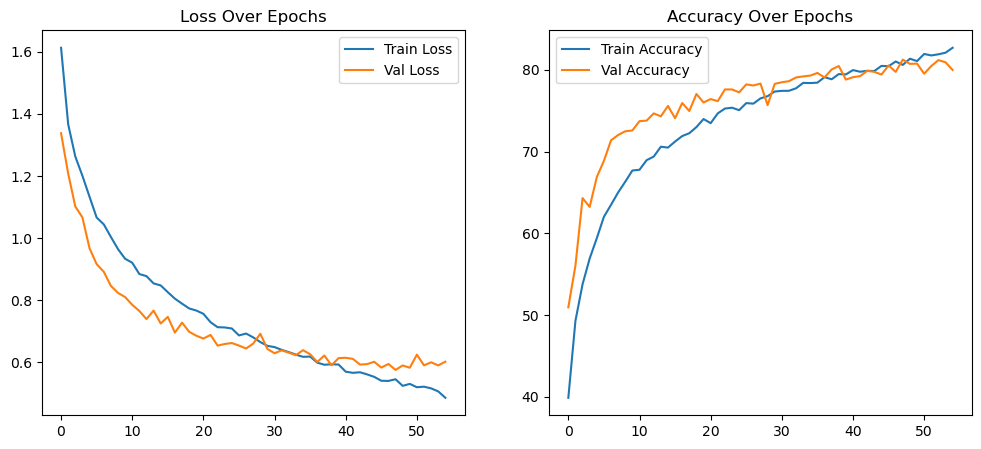

In [82]:
# Drawing training curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

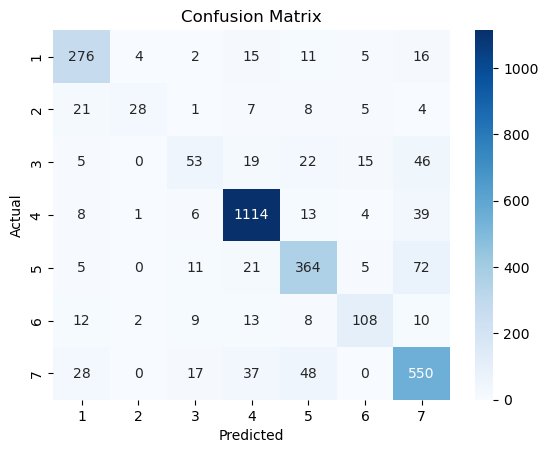

Classification Report:

              precision    recall  f1-score   support

           1       0.78      0.84      0.81       329
           2       0.80      0.38      0.51        74
           3       0.54      0.33      0.41       160
           4       0.91      0.94      0.92      1185
           5       0.77      0.76      0.76       478
           6       0.76      0.67      0.71       162
           7       0.75      0.81      0.78       680

    accuracy                           0.81      3068
   macro avg       0.76      0.68      0.70      3068
weighted avg       0.81      0.81      0.81      3068



In [83]:
# Confusion Matrix
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert the index to category name
label_names = train_dataset.classes
all_labels = [label_names[label] for label in all_labels]
all_preds = [label_names[pred] for pred in all_preds]

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_names))



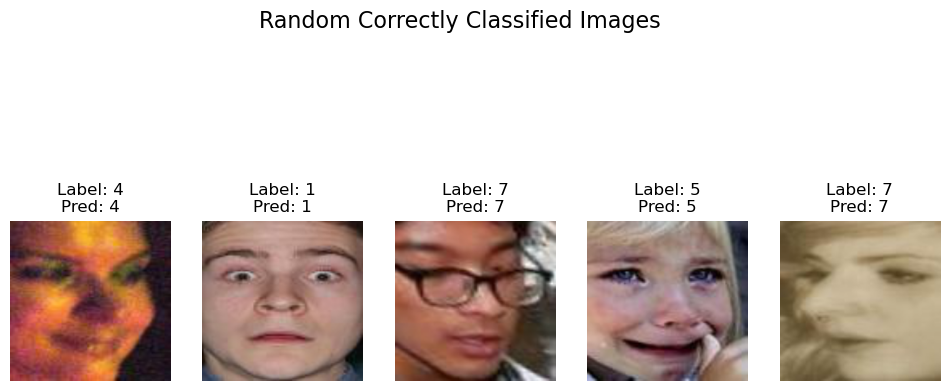

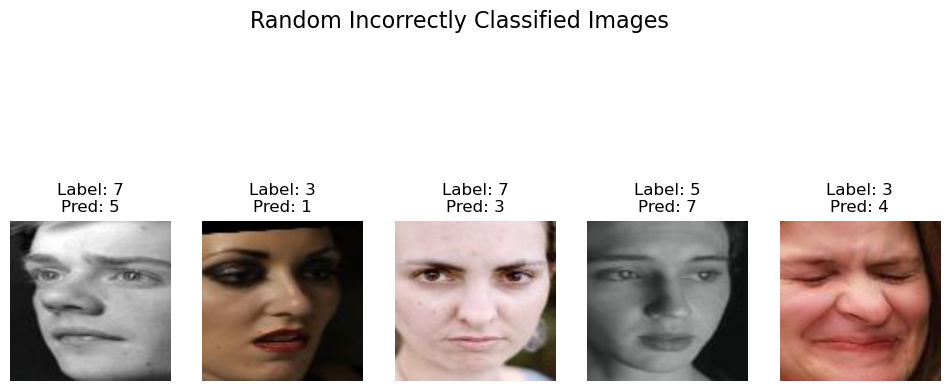

In [84]:
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)


all_correct = []
all_incorrect = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        
        for img, label, pred in zip(images, labels, predicted):
            img_np = denormalize(img)
            if label == pred:
                all_correct.append((img_np, label.item(), pred.item()))
            else:
                all_incorrect.append((img_np, label.item(), pred.item()))


correct_images = random.sample(all_correct, min(5, len(all_correct)))
incorrect_images = random.sample(all_incorrect, min(5, len(all_incorrect)))


def show_images(images, title):
    plt.figure(figsize=(12, 6))
    for i, (img, label, pred) in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {train_dataset.classes[label]}\nPred: {train_dataset.classes[pred]}")
    plt.suptitle(title, fontsize=16)
    plt.show()

if correct_images:
    show_images(correct_images, "Random Correctly Classified Images")
if incorrect_images:
    show_images(incorrect_images, "Random Incorrectly Classified Images")

